In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn 


#now the main libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier #for classifying principal components
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#for metrics and measurement of performance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

#now importing the dataset
from sklearn.datasets import fetch_lfw_people #For Training, Testing and Visualization

#for importing the 
import pickle

In [2]:
#for Visualization
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = lfw_people.images[0].shape



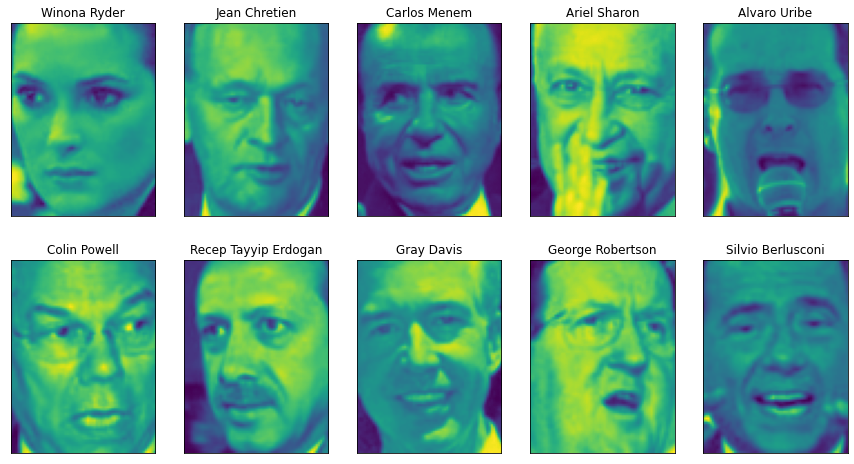

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(lfw_people.target, lfw_people.images, np.ravel(axes)):
    ax.imshow(image)
    ax.set_title(lfw_people.target_names[target])
#plt.savefig("Faces.png")

In [4]:
#To Detect if the Dataset is a bit skewed
counts = np.bincount(lfw_people.target)

for i, (count, name) in enumerate(zip(counts, lfw_people.target_names)):
    print("{0:25} {1:3}".format(name, count), end="  ")
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39  Alvaro Uribe               35  Amelie Mauresmo            21  
Andre Agassi               36  Angelina Jolie             20  Ariel Sharon               77  
Arnold Schwarzenegger      42  Atal Bihari Vajpayee       24  Bill Clinton               29  
Carlos Menem               21  Colin Powell              236  David Beckham              31  
Donald Rumsfeld           121  George Robertson           22  George W Bush             530  
Gerhard Schroeder         109  Gloria Macapagal Arroyo    44  Gray Davis                 26  
Guillermo Coria            30  Hamid Karzai               22  Hans Blix                  39  
Hugo Chavez                71  Igor Ivanov                20  Jack Straw                 28  
Jacques Chirac             52  Jean Chretien              55  Jennifer Aniston           21  
Jennifer Capriati          42  Jennifer Lopez             21  Jeremy Greenstock          24  
Jiang Zemin                20  John Ashcroft              53

## We will now be be minimizing the bin counts since there is a large occurence of Pres. George Bush

In [5]:
#to ensure even distribution of data
mask = np.zeros(lfw_people.target.shape, dtype=np.bool)
for target in np.unique(lfw_people.target):
    mask[np.where(lfw_people.target == target)[0][:50]] = 1
X = lfw_people.data[mask]
y = lfw_people.target[mask]

#scaling the faces into grayscale
X = X / 255

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = PCA(n_components=150, whiten=True, svd_solver="randomized", random_state=42)
pipeline_1 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model)
])

pipeline_1.fit(X_train, Y_train)
X_train_PCA = pipeline_1.transform(X_train)
X_test_PCA = pipeline_1.transform(X_test)

## Now To Test if the model performs well in a classifying algorithm

In [7]:
model_2 = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean")

pipeline_2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_2)
])

pipeline_2.fit(X_train_PCA, Y_train)
print(f"Testing The Score: {pipeline_2.score(X_test_PCA, Y_test)}")

Testing The Score: 0.33171912832929784


In [8]:
#Getting the perfect model
#Trying Logistic Regression
model_3 = LogisticRegression(C=10, penalty="l2", solver="lbfgs")

pipeline_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_3)
])

pipeline_3.fit(X_train_PCA, Y_train)
print(f"Testing The Score: {pipeline_3.score(X_test_PCA, Y_test)}")

Testing The Score: 0.4794188861985472


In [9]:
#Getting the perfect model
#Trying Support Vector Classifier
model_4 = SVC(kernel="rbf", C=10, gamma=0.001, probability=True)

pipeline_4 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_4)
])

pipeline_4.fit(X_train_PCA, Y_train)
print(f"Testing The Score: {pipeline_4.score(X_test_PCA, Y_test)}")

Testing The Score: 0.5351089588377724


## Doing Cross Validation to get the best model

In [12]:
score_1 = cross_val_score(pipeline_2, X, y, cv=5, scoring="accuracy", n_jobs=-1)
score_2 = cross_val_score(pipeline_3, X, y, cv=5, scoring="accuracy", n_jobs=-1)
score_3 = cross_val_score(pipeline_4, X, y, cv=5, scoring="accuracy", n_jobs=-1)

print(f"KNN's Cross Validation Score: {round(score_1.mean(), 4)}")
print(f"Logsistic Regression's Cross Validation Score: {round(score_2.mean(), 4)}")
print(f"Support Vector Classifier's Cross Validation Score: {round(score_3.mean(), 4)}")

KNN's Cross Validation Score: 0.2705
Logsistic Regression's Cross Validation Score: 0.5778
Support Vector Classifier's Cross Validation Score: 0.1944


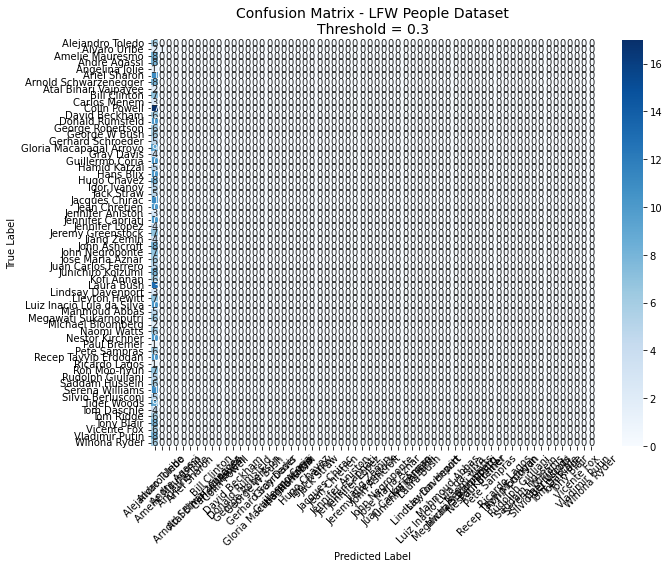

In [21]:
#we're using the support vector classifier pipeline (though it determined low cross validation score; but it has high accuracy-since its only classification so why not)
pipeline_4.named_steps['model'].set_params(probability=True)
y_pred = pipeline_4.predict(X_test_PCA)

y_proba = pipeline_4.predict_proba(X_test_PCA)[:, 1]
#First Threshold Tunning
y_prob = (y_proba >= 0.3).astype(int)
cm = confusion_matrix(Y_test, y_prob)
target_names = lfw_people.target_names

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - LFW People Dataset\nThreshold = 0.3', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig("Confusion Matrix for Custom Threshold (0.3).png")
plt.show()

<Figure size 1080x432 with 0 Axes>

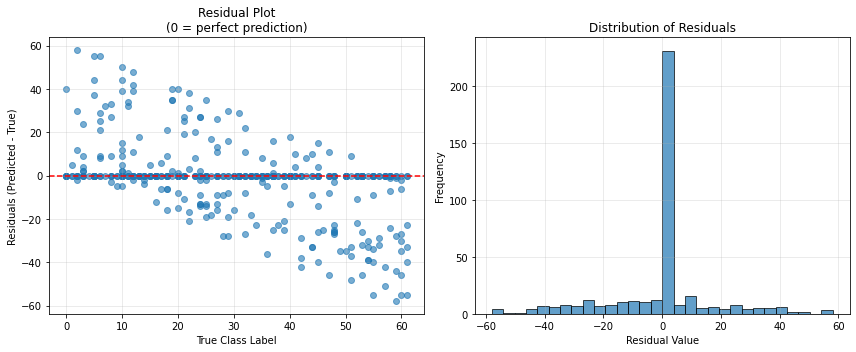

In [14]:
#computing the residuals
plt.figure(figsize=(15, 6))
# Get predictions and probabilities
y_pred = pipeline_4.predict(X_test_PCA)
y_proba = pipeline_4.predict_proba(X_test_PCA)

# Calculate residuals (difference between predicted class and actual class)
residuals = y_pred - Y_test

plt.figure(figsize=(12, 5))

# Residual plot
plt.subplot(1, 2, 1)
plt.scatter(Y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Class Label')
plt.ylabel('Residuals (Predicted - True)')
plt.title('Residual Plot\n(0 = perfect prediction)')
#plt.savefig("Residual Plot.png")
plt.grid(True, alpha=0.3)

# Residual distribution
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
#plt.savefig("Distribution of Residuals.png")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Number of classes: 62
Target names: ['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Williams' 'Silvi

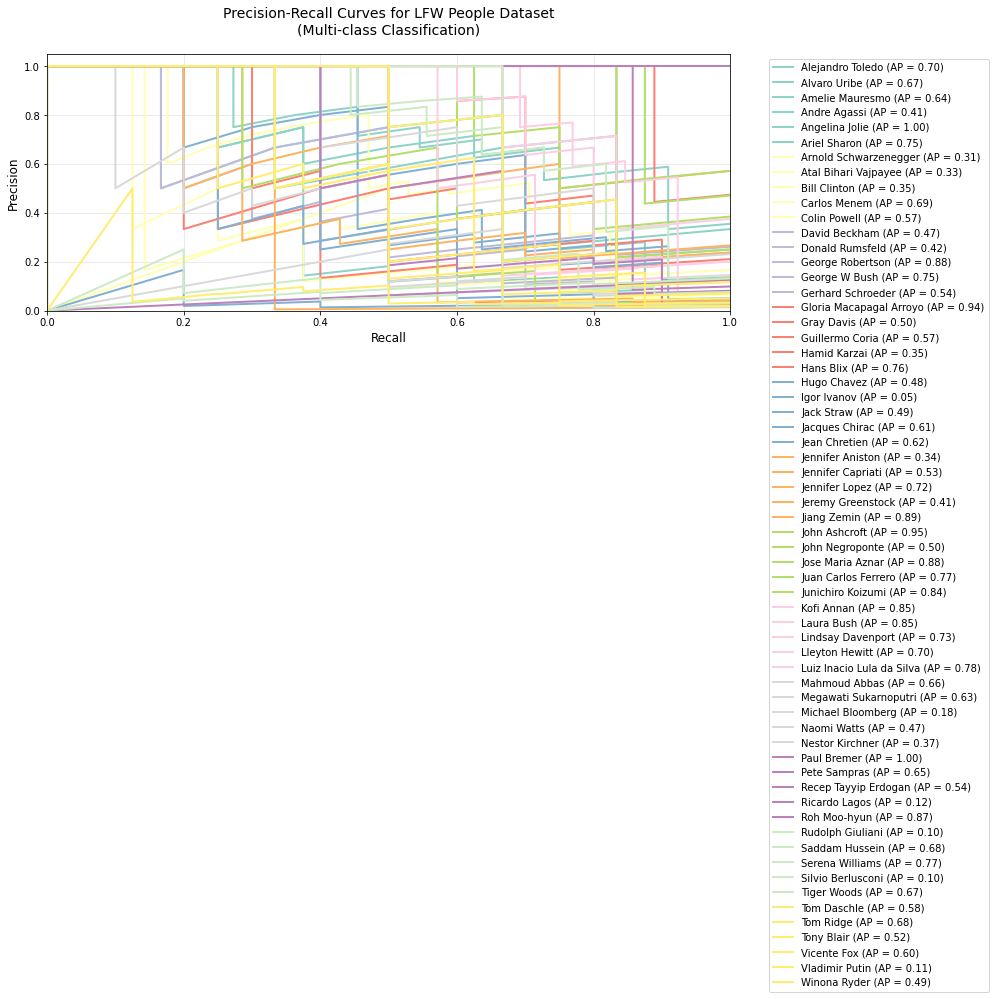

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities
y_proba = pipeline_4.predict_proba(X_test_PCA)

# Binarize the true labels for multi-class
y_test_bin = label_binarize(Y_test, classes=np.unique(Y_test))
n_classes = y_test_bin.shape[1]

print(f"Number of classes: {n_classes}")
print(f"Target names: {target_names}")

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(14, 10))

# Use a colormap for better distinction
colors = plt.cm.Set3(np.linspace(0, 1, n_classes))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, 
             label=f'{target_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves for LFW People Dataset\n(Multi-class Classification)', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig("Precision_Recall_Curve_MultiClass.png", dpi=300, bbox_inches='tight')
plt.show()

## Observing The Performance of The model by visualizing its test sets

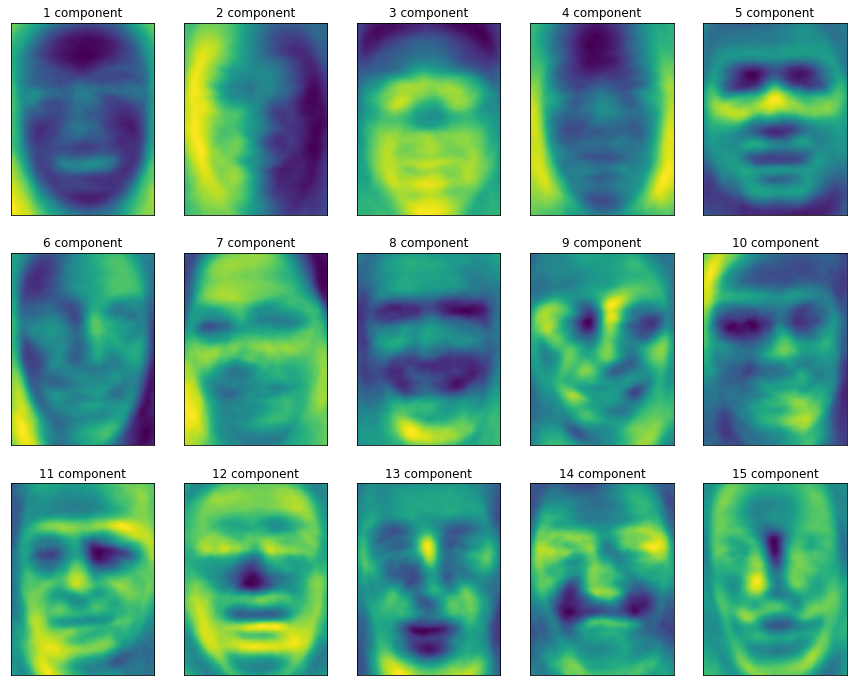

In [11]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (components, ax) in enumerate(zip(model.components_, np.ravel(axes))):
    ax.imshow(components.reshape(image_shape), cmap='viridis')
    ax.set_title("{} component".format((i + 1)))
#plt.savefig("Model Performance.png")

## Visualizing The Actual Test Set Generated by the model

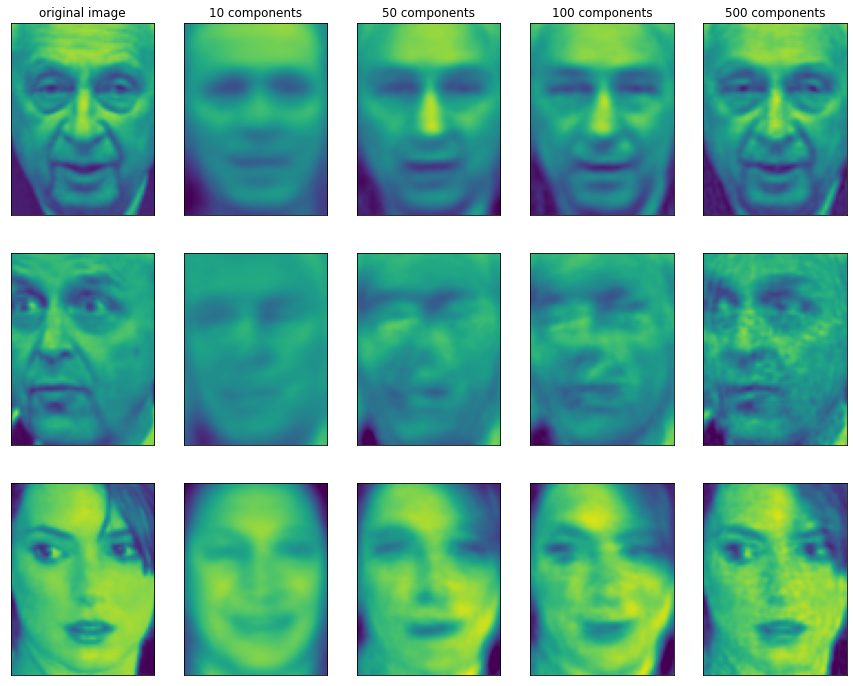

In [14]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)
#plt.savefig("Generated Faces by Mglearn.png")

## Now we Visualize the Images Depending on its Distribution

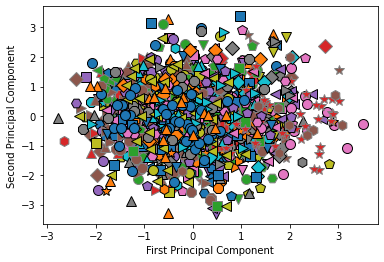

In [16]:
mglearn.discrete_scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], Y_train)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.savefig("Distribution of Components.png")

## Using Non Matrix Factorization to Extract Significance

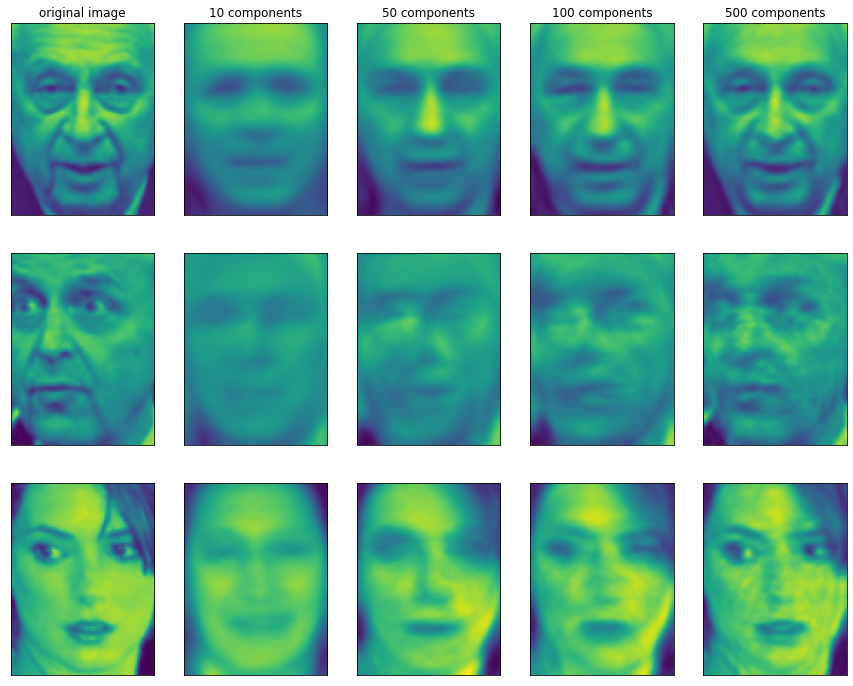

In [21]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)
#plt.savefig("Using Non Matrix Factorization.png")

In [29]:
#Extracting Model for Learning Reference
with open("model.pkl", "wb") as pca:
    pickle.dump(pipeline_4, pca)
    
#Extracting the best threshold
with open("best_threshold.pkl", "wb") as thres:
    pickle.dump(y_prob, thres)
